In [2]:
import time

import numpy as np

from configs import get_gan_default_config
from utils.hist import HistogramExperiment
from utils.utils import experiment_save_results

In [3]:
g = {}
c = {}
delta = {}

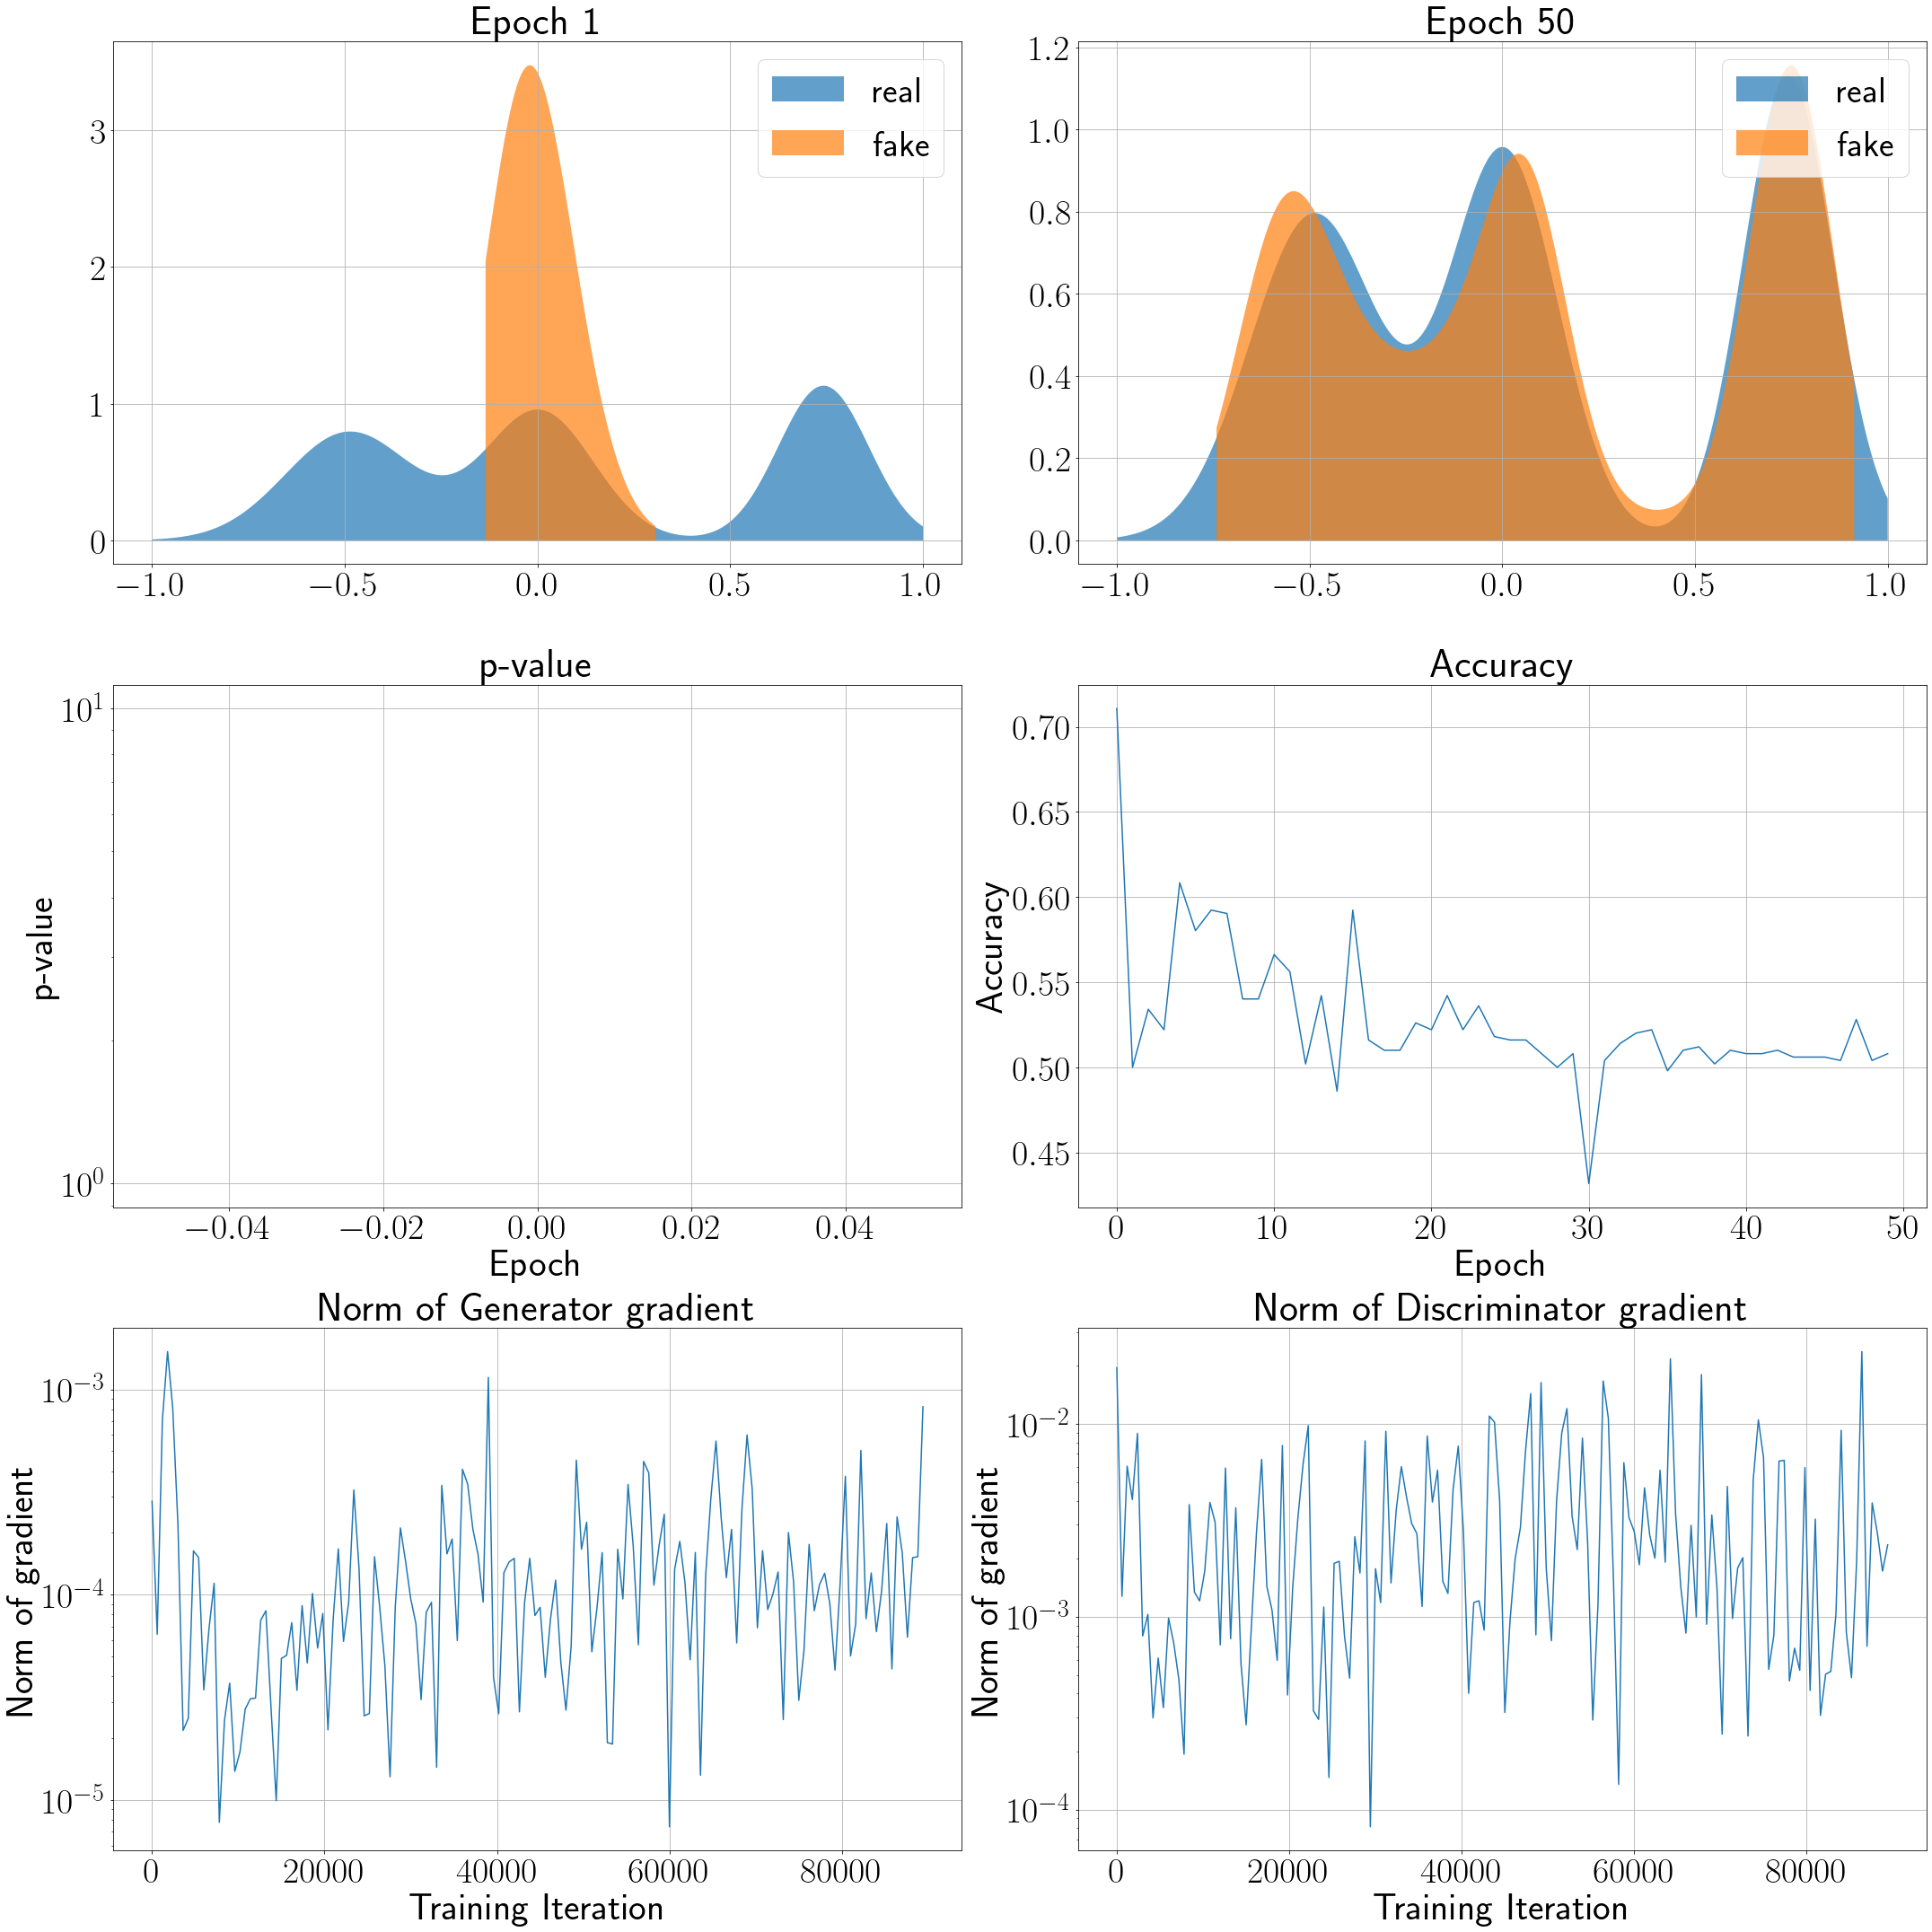

In [5]:
for sn in True, False:
    for n_cr in [2, 4, 6]:
        exp_name = f"sn_ncr{n_cr}" if sn else f"ncr{n_cr}"
        config = get_gan_default_config(n_cr=n_cr, exp_name=exp_name, sn=True)
        hist = HistogramExperiment(config)
        start = time.time()
        g[n_cr], c[n_cr], train_losses = experiment_save_results(hist)
        end = time.time()
        delta[n_cr] = end-start
        np.save(f"results/{exp_name}/p", train_losses["pvals"])
        np.save(f"results/{exp_name}/c_grad", train_losses["c_grad"])
        np.save(f"results/{exp_name}/g_grad", train_losses["g_grad"])
    

In [ ]:
from utils.utils import compare_pvals, sn2nosn
compare_pvals()

In [ ]:
sn2nosn()


In [47]:
delta


{2: 234.82655310630798, 4: 209.77042508125305, 6: 205.16864585876465}